# Analysis of generalizability and $n^*$

This notebook analyzes the results of `demo1_estimate_nstar.ipynb` to investigate the dependency between the desired generalizability $\alpha^*$, the similarity threshold for rankings $\delta^*$, and the number of experimental conditions that guarantee generalizable results $n^*$. 

## Imports and configuration

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import yaml

from pathlib import Path
from tqdm.auto import tqdm

Next, we load the parameters from the configuration file. 

In [5]:
with open("config.yaml", 'r') as file:
    config = yaml.safe_load(file)

OUTPUT_DIR = Path(config['paths']['output_dir'])
FIGURES_DIR = Path(config['paths']['figures_dir'])
FIGURES_DIR.mkdir(exist_ok=True, parents=True)

DATASET = Path(config['data']['dataset_path'])
EXPERIMENTAL_FACTORS = config['data']['experimental_factors']
TARGET = config['data']['target']
ALTERNATIVES = config['data']['alternatives']

## Loading 

We concatenate all of the output dataframes and add a column with the number of datasets we have results on, conditioned on (model, tuning, scoring). In the terminology of the paper, we fix the held-constant and design factors and count the number of levels of the allowed-to-vary factor. 

In [6]:
df_nstar = pd.concat([pd.read_parquet(x) 
                      for x in tqdm(list(OUTPUT_DIR.glob("**/**/**/nstar.parquet")), 
                                    desc="Loading dataframes")]).reset_index(drop=True)

fixed_factors = [factor for factor, lvl in EXPERIMENTAL_FACTORS.items() if lvl == "_all"]  
df_nstar = df_nstar.join(df_nstar.groupby(fixed_factors)["N"].max(), on=fixed_factors, rsuffix="max")

Loading dataframes:   0%|          | 0/1296 [00:00<?, ?it/s]

## Plot parameters

In [7]:
sns.set(style="ticks", context="paper", font="times new roman")

# mpl.use("TkAgg")
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r"""
    \usepackage{mathptmx}
    \usepackage{amsmath}
"""
mpl.rc('font', family='Times New Roman')

# pretty names
pc = {"alpha": r"$\alpha^*$", "eps": r"$\varepsilon^*$", "nstar": r"$n^*$", "delta": r"$\delta^*$", "N": r"$N$", "nstar_absrel_error": "relative error"}  # columns
pk = {"borda_kernel_idx_OHE": r"$\kappa_b^{\text{OHE}, 1/n}$", "mallows_kernel_nu_auto": r"$\kappa_m^{1/\binom{n}{2}}$", "jaccard_kernel_k_1": r"$\kappa_j^{1}$"}  # kernels
pk.update({"borda_kernel_idx_OHE": "$g_1$", "mallows_kernel_nu_auto": "$g_3$", "jaccard_kernel_k_1": "$g_2$"})  # rename to goal_1, 2, 3

The following function outputs a very conservative upper bound for $n^*$.

In [8]:
@np.vectorize
def theoretical_nstar(alphastar, epsstar, kbar=1):
    beta1 = -2
    beta0 = 2*np.log(np.sqrt(2*kbar) + np.sqrt(-4*kbar * np.log(1-alphastar)))
    return np.exp(beta0 + beta1*np.log(epsstar))

## How $n^*$ depends on $\alpha^*$ and $\delta^*$

We can finally visualize how $n^*$ depends on $\alpha^*$ and $\delta^*$. 
To do so, we first fix $a\alpha^* = 0.05$ and then $\delta^* = 0.05$ (corresponding to $\varepsilon(\delta^*) \approx 0.31$).

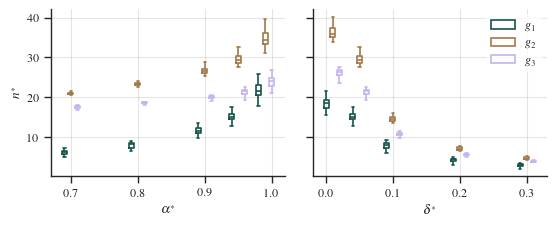

In [13]:
alpha_fixed = 0.95
delta_fixed = 0.05
eps_fixed = 0.31


plt.close("all")
fig, axes = plt.subplots(1, 2, figsize=(5.5, 5.5/2.5), width_ratios=(1, 1), sharey=True)

# ----  ALPHA
ax = axes[0]
dfplot = df_nstar.loc[(df_nstar["delta"] == delta_fixed) & (df_nstar["N"] == df_nstar["Nmax"])]

# Make dfplot pretty
dfplot = dfplot.rename(columns=pc)
dfplot["kernel"] = dfplot["kernel"].map(pk)
dfplot["nstar_th"] = theoretical_nstar(dfplot[pc["alpha"]], dfplot[pc["eps"]], kbar=1)

# Plot
sns.boxplot(dfplot, x=pc["alpha"], y=pc["nstar"], ax=ax, hue="kernel", showfliers=False, palette="cubehelix",
            dodge=True, native_scale=True, fill=False, legend=False,
            width=0.75, boxprops={"linewidth": 1.2}, gap=0.25)
# ax.set(xticks=[0.7, 0.8, 0.9, 0.99])
ax.grid(color="grey", alpha=0.2)

# Uncomment to plot the conservative estimate for nstar
# alphas = np.linspace(dfplot[pc["alpha"]].min(), dfplot[pc["alpha"]].max(), 100)
# nstars_th = theoretical_nstar(alphas, eps_fixed)
# sns.lineplot(x=alphas, y=nstars_th, ax=ax, c="black", linewidth=0.5)  

# ----  DELTA
ax = axes[1]
dfplot = df_nstar.loc[(df_nstar["alpha"] == alpha_fixed) & (df_nstar["N"] == df_nstar["Nmax"])]

# Make dfplot pretty
dfplot = dfplot.rename(columns=pc)
dfplot["kernel"] = dfplot["kernel"].map(pk)

# plot
sns.boxplot(dfplot, x=pc["delta"], y=pc["nstar"], ax=ax, hue="kernel", showfliers=False, palette="cubehelix",
            dodge=True, native_scale=True, fill=False, legend=True,
            width=0.75, boxprops={"linewidth": 1.2}, gap=0.25)
# ax.set(xticks=[0.01, 0.1, 0.2, 0.3])
ax.grid(color="grey", alpha=0.2)

# Uncomment to plot the conservative estimate for nstar
# epss = np.linspace(dfplot[pc["eps"]].min(), dfplot[pc["eps"]].max(), 100)
# nstars_th = theoretical_nstar(alpha_fixed, epss)
# # sns.lineplot(x=epss, y=nstars_th, ax=ax, c="black", linewidth=0.5) 

ax.legend(*ax.get_legend_handles_labels()).get_frame().set_edgecolor("w")

sns.despine(right=True, top=True)
plt.tight_layout(pad=.5)
plt.subplots_adjust(wspace=.12)
plt.savefig(FIGURES_DIR / "encoders_nstar_alpha_delta.pdf")
# plt.savefig(FIGURES_DIR / "encoders_nstar_alpha_delta_upperbound.pdf")
plt.show()

### Most and least generalizable combinations of design factors

In [10]:
kernel = "jaccard_kernel_k_1"

df_ = df_nstar.query("kernel==@kernel and alpha==@alpha_fixed and delta==@delta_fixed")
df_ = df_.loc[df_["N"] == df_["Nmax"]]
df_.loc[(df_["nstar"] == df_["nstar"].min()) | (df_["nstar"] == df_["nstar"].max())]

,kernel,alpha,eps,delta,disjoint,replace,N,nstar,nstar_lower,nstar_upper,variance,var_lower_bound,model,tuning,scoring,Nmax
1900,jaccard_kernel_k_1,0.95,0.316228,0.05,True,False,50,33.393662,33.075697,33.743204,0.905270,0.855461,KNC,model,AUC,50
2873,jaccard_kernel_k_1,0.95,0.316228,0.05,True,False,30,27.501349,26.991662,27.773651,0.961119,0.670853,LGBMC,no,AUC,30


## How $n^*$ depends on $N$

We estimate the $(\alpha^*, \delta^*)$-generalizability on a sample of $N$ results.
This section shows how the estimate of $n^*$ changes with bigger samples.
In particular, we want to know how large $N$ should be to get an estimate for $n^*$ which is "close enough" to the estimate we get at $N=50$.

In [11]:
nstar_50 = df_nstar.loc[df_nstar["N"] == df_nstar["Nmax"]].drop(columns=["N", "Nmax"])
keys = ["kernel", "alpha", "eps", "model", "tuning", "scoring"]
df_ = pd.merge(df_nstar, nstar_50, left_on=keys, right_on=keys, suffixes=("", "_true"))[keys + ["nstar", "nstar_true", "N", "Nmax"]]
df_["nstar_error"] = df_["nstar"] - df_["nstar_true"]
df_["nstar_relative_error"] = (df_["nstar"] - df_["nstar_true"]) / df_["nstar_true"]
df_["nstar_absolute_error"] = np.abs(df_["nstar"] - df_["nstar_true"])
df_["nstar_absrel_error"] = np.abs(df_["nstar"] - df_["nstar_true"]) / df_["nstar_true"]
# df_ = df_.loc[df_["N"] != df_["Nmax"]]
df_ = df_.query("Nmax == 50")

dfplot = df_.copy().query("N < Nmax").rename(columns=pc)
dfplot["kernel"] = dfplot["kernel"].map(pk)

y = pc["nstar_absrel_error"]

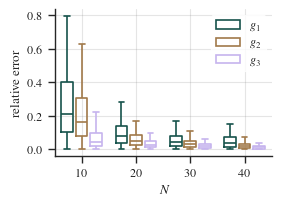

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(5.5/2, 2))

sns.boxplot(dfplot, x=pc["N"], y=y, showfliers=False, fliersize=0.3, hue="kernel", palette="cubehelix", ax=ax, legend=True, linewidth=1.2, fill=False, gap=0.2)  

ax.grid(color="grey", alpha=.2)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8])

ax.legend(*ax.get_legend_handles_labels()).get_frame().set_edgecolor("w")
sns.despine()
plt.tight_layout(pad=.5)

plt.savefig(FIGURES_DIR / "encoders_nstar_absrel_error.pdf")
plt.show()